# Introduction to Store Sales Forecasting

In today's competitive retail landscape, accurately predicting future sales is crucial for businesses to make informed decisions, optimize resources, and maintain a competitive edge. Store Sales Forecasting leverages historical data, statistical methods, and machine learning models to estimate future sales. This approach helps retailers and decision-makers anticipate **customer demand, manage inventory levels, and create effective sales and marketing strategies**.


# What is Store Sales Forecasting?

Store Sales Forecasting involves predicting the revenue or sales volume for individual stores or across retail networks over a specific time period. By using **historical sales data** and considering **external factors, such as holidays, events, economic trends, economy,and weather patterns**, forecasting models can project future sales patterns. These forecasts can range from short-term predictions (daily or weekly sales) to long-term forecasts (monthly or yearly sales), helping businesses strategically plan their operations.


## Challenges in Store Sales Forecasting

- **Trend** : Sales changes with respect to time, trend is defined as the rate of change
- **Seasonality** :  Many products experience seasonal fluctuations, making it necessary for models to account for time-based patterns.
- **External Influences**: Events like holidays, economic conditions, local events, and weather can significantly impact sales and must be factored into forecasts.
- **Store-Specific Variability**: Each store may have unique characteristics (seasonality and trend) due to the location and customer demographics that influence sales, making it essential to tailor forecasts for individual stores

**Ecquador economy depends upon the oil. So, it's necessary to kepp oil prices in account**

## Approach

### Data cleaning

- Data cleaning helps to judge the quality of data, while data cleaning we can check and fill empty values, check shape, find that are related to each other.

### EDA

- During **EDA**, I tried to study sales of different family, stores, seasonality, trend, and effect of external factors that effect sales.

### Data Engineering

- As per the **EDA** findings, I have created features like **seasonality**, **trend**, **lags**, **time features**.

### Model Selection

- I have selected **XGBoost Model** due to its readiness to handle complex datasets.

### Model Evalution

- I have create three XGBoost models with three different approaches and calculated their effectiveness using **RMSLE, R square**.
  1. **First Approach** - I have used data without any transformation.
  2. **Second Approach** - I have removed outliers
  3. **Third Approach** - I have used log transformation on dependent variable. Log transformations helps to find the non linear relationship between the variables.
 
## Result

- I have used Third Model because of the better performance than others, calculated using **RMSLE, R square**.

In [78]:
import pandas as pd
import numpy as np
import warnings
import os
from datetime import datetime, timedelta
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier,DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  r2_score, root_mean_squared_error as RMSE, mean_absolute_percentage_error as MAPE, root_mean_squared_log_error as RMSLE
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [79]:
# Load Datasets
Holiday_events = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\holidays_events.csv", parse_dates=["date"])
Oil = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\oil.csv", parse_dates=["date"])
stores = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\stores.csv")
transactions = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\transactions.csv", parse_dates=["date"])
train =  pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\train.csv", parse_dates=["date"])
test = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\test.csv", parse_dates=["date"])

In [80]:
pd.set_option("display.float_format", lambda x:"%.3f"%x)

## Data Cleaning

In [81]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [82]:
Oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [83]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [84]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

## Preprocessing Functions

In [85]:
def string_processing(data, columns):
    '''
    data : Table for transformation
    columns : list of string columns
    '''
    for i in columns:
        data[i] = data[i].str.strip().str.upper()
    return data

In [86]:
def Holiday_func(tbl):
    """
    tbl : Holiday table
    """
    Local = tbl[tbl["locale"] == 'Local']
    Regional = tbl[tbl["locale"] == 'Regional']
    National = tbl[tbl["locale_name"].str.contains('Ecuador')]
    prefix = ["Local_","Regional_","National_"]
    diff_type = [Local, Regional, National]
    for i in range(3):
        diff_type[i] = diff_type[i][["date", "locale_name","type"]]
        diff_type[i]["values"] = 1
        diff_type[i]["type"] = prefix[i] + diff_type[i]["type"]
        diff_type[i].drop_duplicates(inplace=True)
        diff_type[i] = diff_type[i].pivot_table(index=["date", 'locale_name'], columns=["type"], values="values",aggfunc='mean', fill_value=0).reset_index()
        diff_type[i] = string_processing(diff_type[i], ['locale_name'])
    
    return diff_type[0], diff_type[1], diff_type[2]


In [87]:
def merge_tables(data,transactions, Oil, stores, National, Local, Regional):
    """
    data : Base transaction table
    transactions : transactions over the years
    Oil : Oil prices over the years 
    stores : Store details table
    National : National Event Table
    Local : Local Event Table
    Regional : Regional Event Table
    """
    input1 = pd.merge(data, transactions, left_on = ["date", "store_nbr"], right_on=["date","store_nbr"], how = "left")
    input2 = pd.merge(input1, Oil, on = ["date"], how="left")
    input3 = pd.merge(input2, stores, on = ["store_nbr"], how="left")
    input4 = pd.merge(input3, National, left_on = 'date', right_on='date', how = 'left')
    input4 = pd.merge(input4, Local, left_on=["date", "city"], right_on=["date","locale_name"], how="left")
    input4 = pd.merge(input4, Regional, left_on=["date", "state"], right_on=["date","locale_name"], how="left")
    input4["dcoilwtico"] = input4["dcoilwtico"].ffill().bfill()
    input4.drop(columns=["transactions"], inplace=True)
    input4.fillna(0, inplace=True)
    
    return input4

## EDA

In [88]:
def grp_boxplot(data, clm, target):
    '''
    data : table with store sales
    clm : list of columns for grouping
    target : target value
    '''
    for col in clm:
        sns.catplot(data=data, x = col, y = target, kind='box', height=4, aspect=4)
        plt.xticks(rotation = 90)
        plt.show()

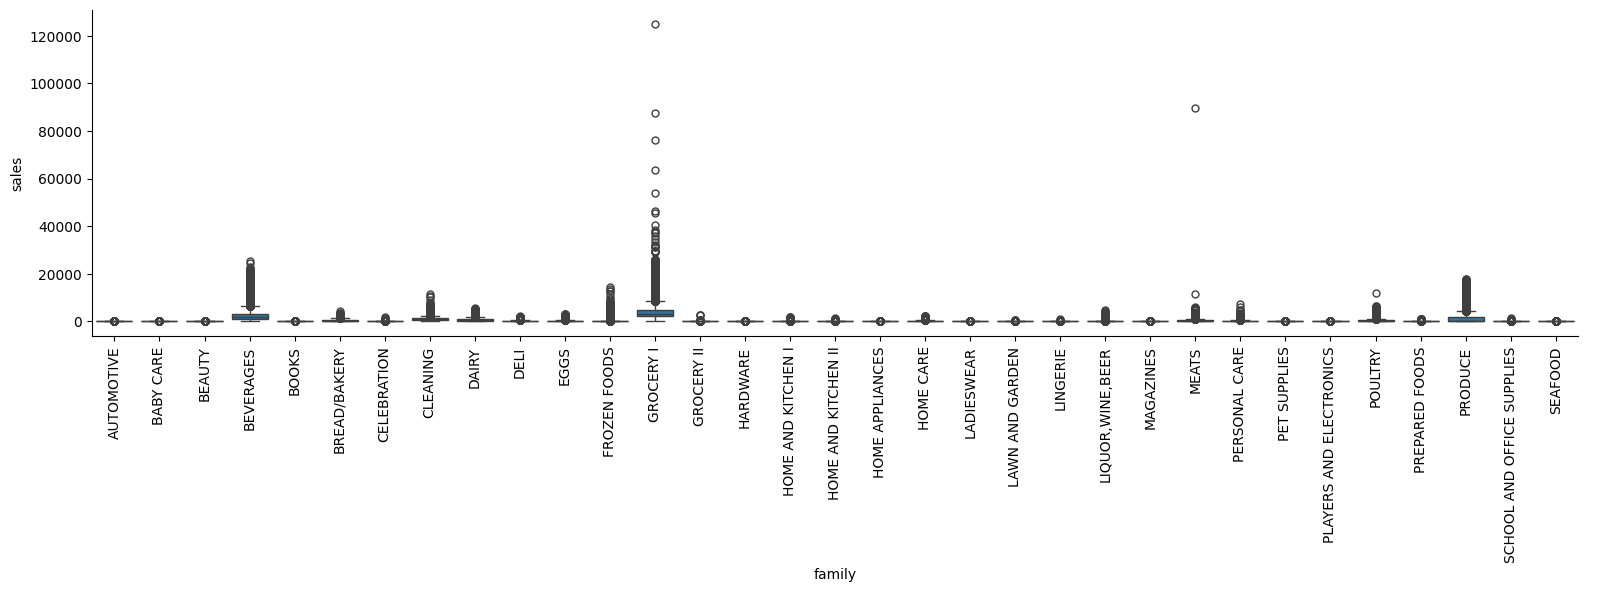

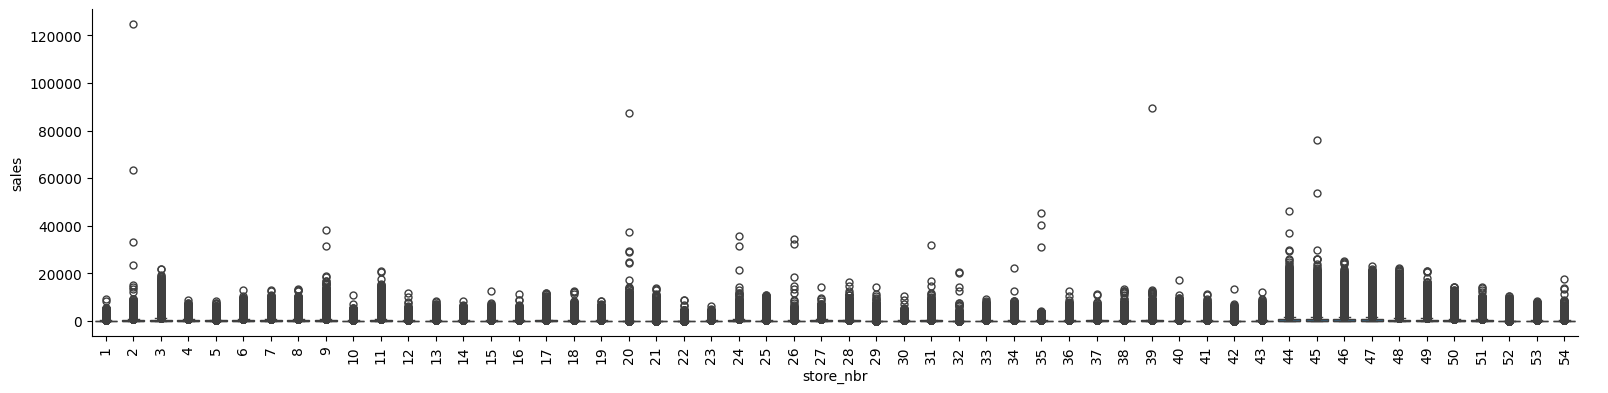

In [89]:
grp_boxplot(train,clm = ['family','store_nbr'],target = 'sales')

In [90]:
def grp_familylineplot(tbl, family):
    '''
    tbl : sales table
    family : list of product family
    '''
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    plot_data = tbl[tbl["family"].isin(family)]
    plot_data = plot_data.groupby(by = ["date","family"],as_index=False)["sales"].mean()
    sns.lineplot(data = plot_data, x="date", y= "sales", hue="family", ax = axs)
    plt.show()

def grp_storelineplot(tbl, store_nbr):
    '''
    tbl : sales table
    store_nbr : list of store number
    '''
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    plot_data = tbl[tbl["store_nbr"].isin(store_nbr)]
    plot_data = plot_data.groupby(by = ["date","store_nbr"],as_index=False)["sales"].mean()
    sns.lineplot(data = plot_data, x="date", y= "sales", hue="store_nbr", ax = axs)
    plt.show()

- There was Non Stocking problem for Celebration, Home and kitchen I, Home and kitchen II, Home Care, Ladieswear, Magazines, Players and Electronics, Pets and Supplies during the period of 2013, and for a brief in the period of 2014.
- Dairy and Poultry Sales spiked after the year 2013.
- Stocking problem for Books and Baby Care for a longer duration. It could be that these items were placed in the later years.
- Frozen Food sales increases during the last month of the sale.
- Store Nbr 42, 52, 53 were opened later in the years.
- Store Nbr 24,25,29,30 were closed inbetween the years.

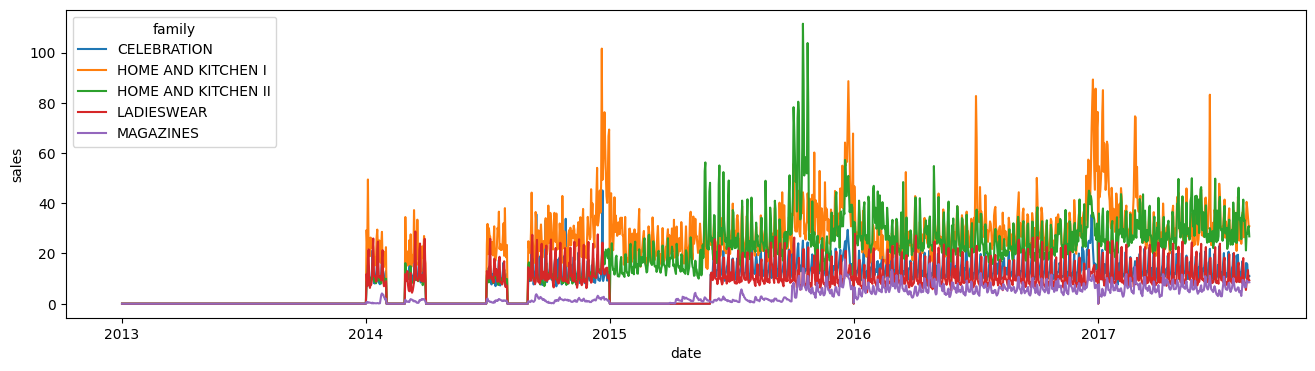

In [91]:
grp_familylineplot(train, family=["CELEBRATION", "MAGAZINES","HOME AND KITCHEN I", "HOME AND KITCHEN II", "LADIESWEAR", "MAGAZINES"])

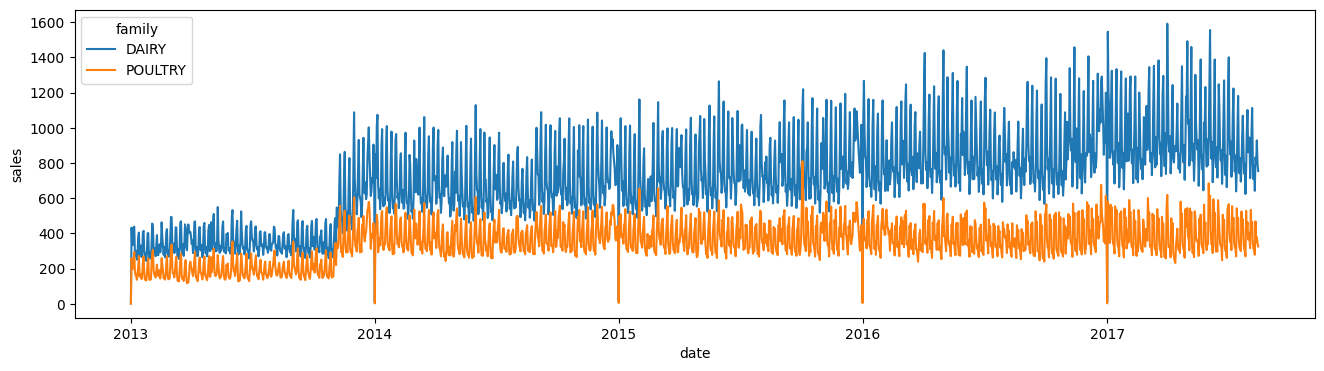

In [92]:
grp_familylineplot(train, family=["DAIRY", "POULTRY"])

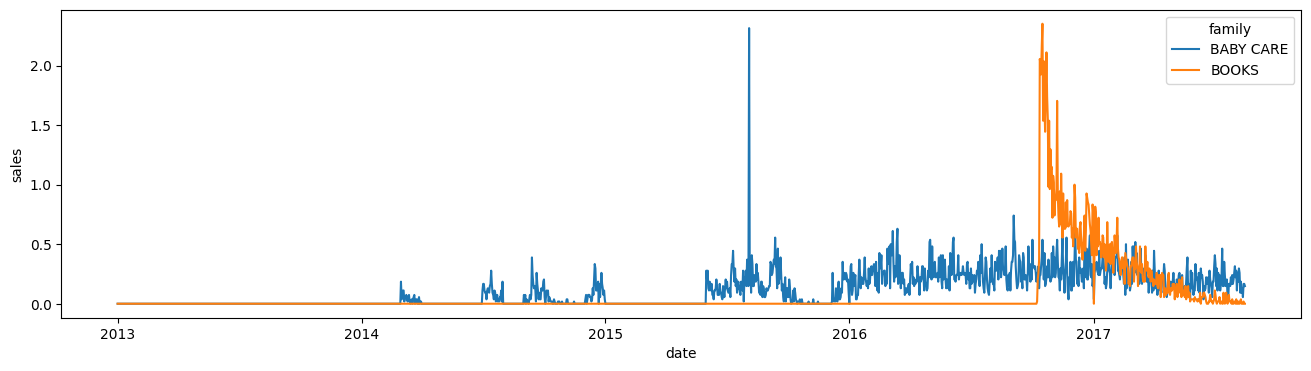

In [93]:
grp_familylineplot(train, family=["BOOKS", "BABY CARE"])

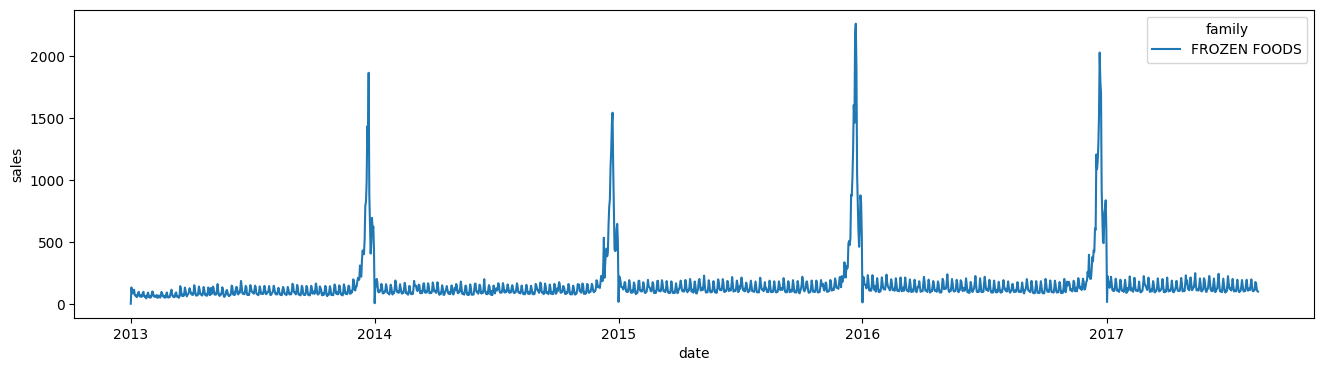

In [94]:
grp_familylineplot(train, family=["FROZEN FOODS"])

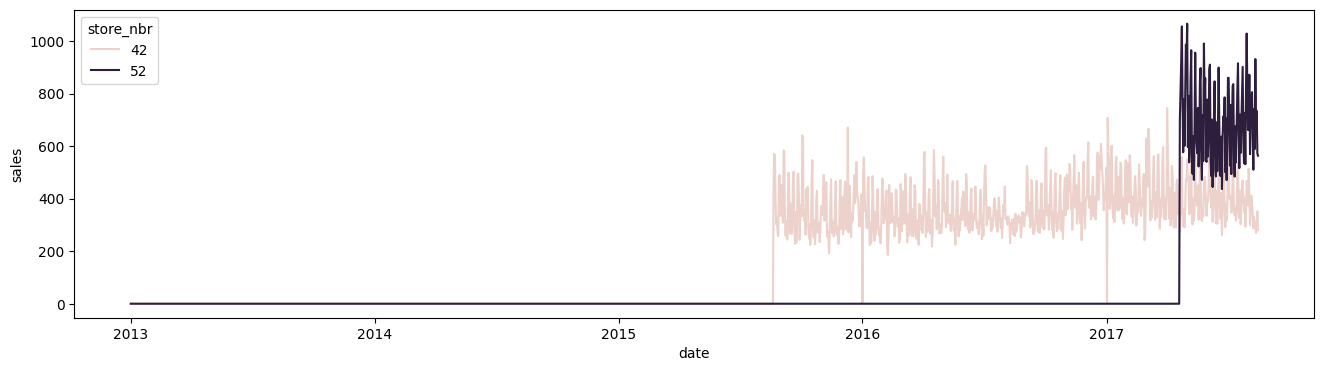

In [95]:
## 24,25,29,30,42,52,53 : these stores were closed in between
grp_storelineplot(train, [42,52])

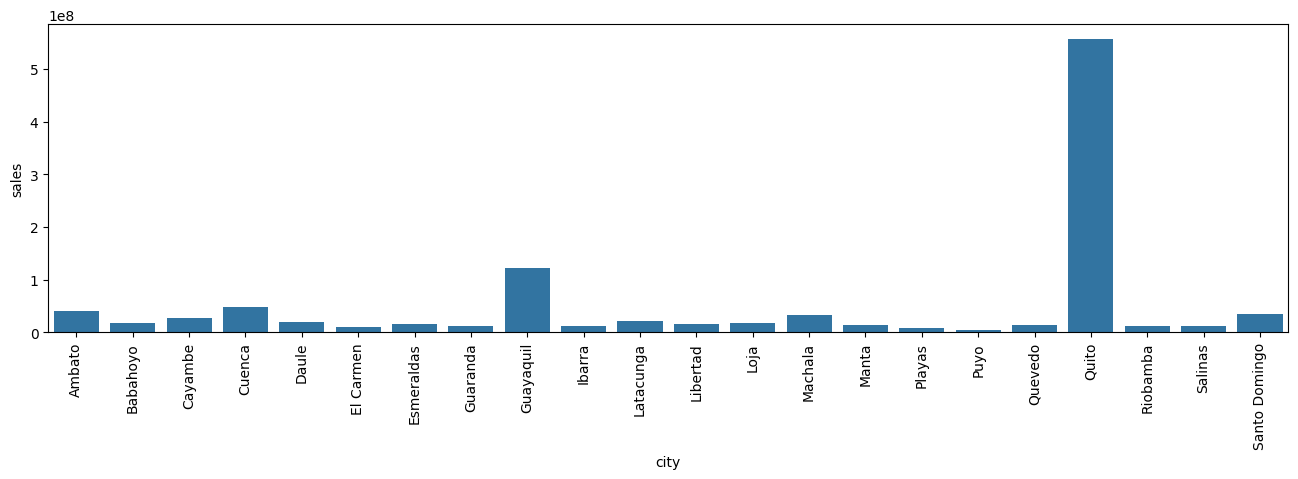

In [96]:
def group_wise_sales(train, stores, clm):
    '''
    train : Train data for sales.
    stores : Stores information
    clm : grouping column
    '''

    data1 = pd.merge(train, stores, left_on=["store_nbr"], right_on = ["store_nbr"], how = "left")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (16,4))
    plot_data = data1.groupby(by = [clm], as_index=False)["sales"].sum()    
    sns.barplot(data=plot_data, x = clm, y = "sales", ax= axs)
    axs.tick_params(axis = 'x', rotation = 90)
    plt.show()

group_wise_sales(train, stores, 'city')

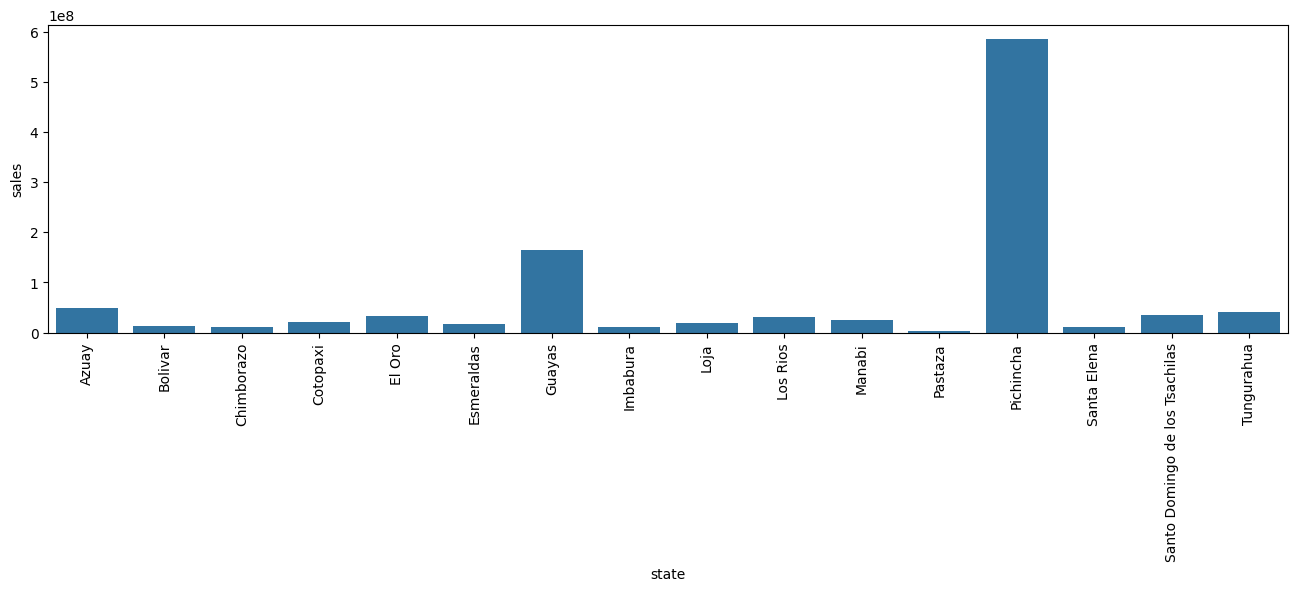

In [97]:
group_wise_sales(train, stores, 'state')

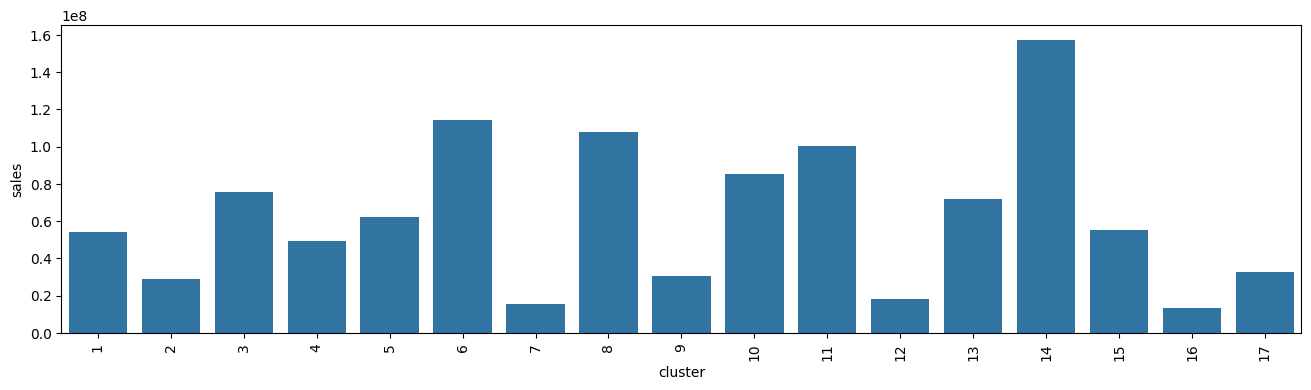

In [98]:
group_wise_sales(train, stores, 'cluster')

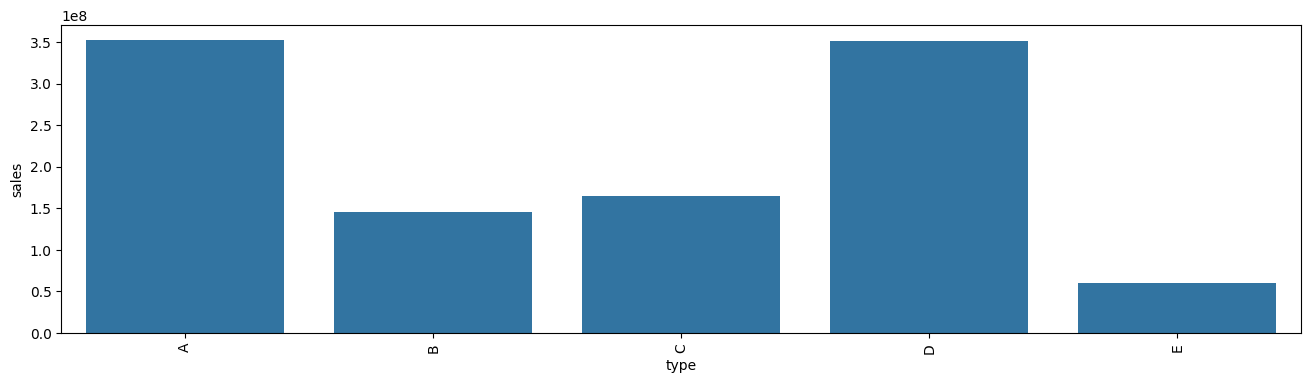

In [99]:
group_wise_sales(train, stores, 'type')

- Sales has right skewed distribution due to a lot of zeroes

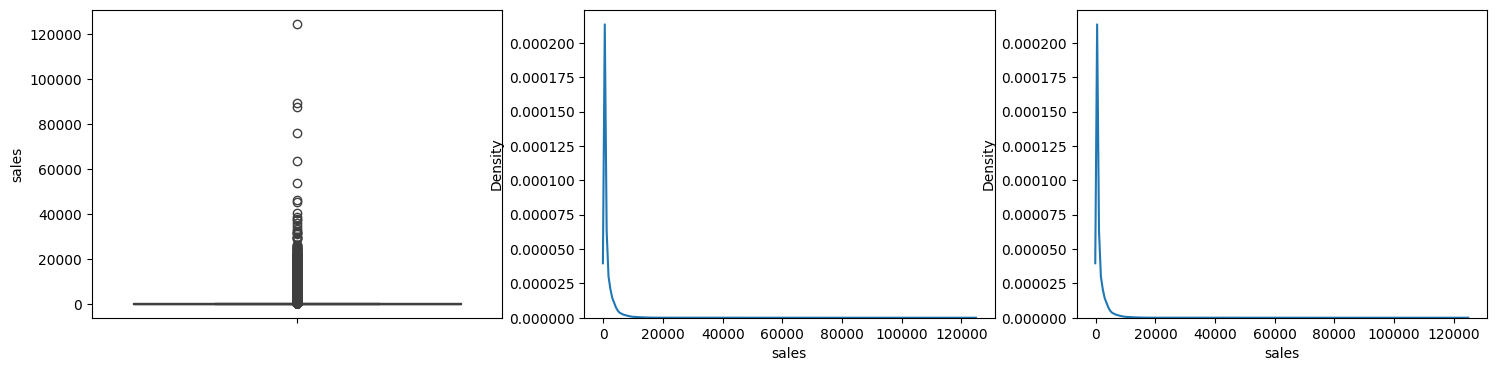

In [100]:
def distribution_plot(tbl,clm):
    '''
    tbl : Tables with the column to find ditribution
    clm : Column whose distribution need to be checked
    '''
    fig, axs = plt.subplots(figsize = (18,4), nrows = 1, ncols = 3)
    sns.boxplot(train["sales"],ax = axs[0])
    sns.kdeplot(train["sales"],ax = axs[1])
    sns.kdeplot(train["sales"],ax = axs[2])
    plt.show()

distribution_plot(train, 'sales')

- Grocery and Beverages are most popular products in a grocery store
- There are multiple Store and Family combination which does not have any sales.

In [101]:
def grp_statistics(data,grp):
    '''
    data : Sales table with the groups
    grp : Different groups in table
    '''
    statistics_input = data.groupby(by = grp)["sales"].describe().reset_index()
    statistics_input.sort_values(by = ["mean"], ascending = False, inplace=True)
    
    return statistics_input

In [102]:
statistics_input = grp_statistics(train,["store_nbr", "family"])
statistics_input.head(20)

,store_nbr,family,count,mean,std,min,25%,50%,75%,max
1431,44,GROCERY I,1684.000,9730.436,3576.086,0.000,7271.000,8804.000,11645.500,46271.000
1464,45,GROCERY I,1684.000,9708.878,3968.979,0.000,7062.750,8975.500,11664.500,76090.000
1530,47,GROCERY I,1684.000,9212.903,3213.630,0.000,6803.250,8537.500,11131.250,23024.000
1497,46,GROCERY I,1684.000,8516.783,3609.152,0.000,5767.250,7330.000,10650.500,25238.000
1422,44,BEVERAGES,1684.000,7967.850,3885.071,0.000,4618.250,7585.500,9608.750,25413.000
78,3,GROCERY I,1684.000,7702.178,2243.045,0.000,6140.750,7263.500,8985.250,21858.000
1563,48,GROCERY I,1684.000,7619.355,3454.844,0.000,5027.500,6446.500,9559.750,22255.000
1455,45,BEVERAGES,1684.000,6751.990,3813.373,0.000,3339.500,6249.500,8799.750,22170.000
69,3,BEVERAGES,1684.000,6740.849,3124.891,0.000,3910.250,6556.500,8407.750,19154.000
1596,49,GROCERY I,1684.000,6584.311,2576.109,0.000,4757.500,6309.500,8052.750,21190.000


In [103]:
statistics_input[statistics_input["max"] == 0]

,store_nbr,family,count,mean,std,min,25%,50%,75%,max
697,22,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1306,40,LADIESWEAR,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1753,54,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1291,40,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1258,39,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1126,35,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
977,30,LAWN AND GARDEN,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
400,13,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
928,29,BOOKS,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1453,45,BABY CARE,1684.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [104]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    '''
    ts : Sales with timeseries index
    '''
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize = (16,4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

- Strong weekly seasonality, along with little semiweekly, yearly seasonality

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

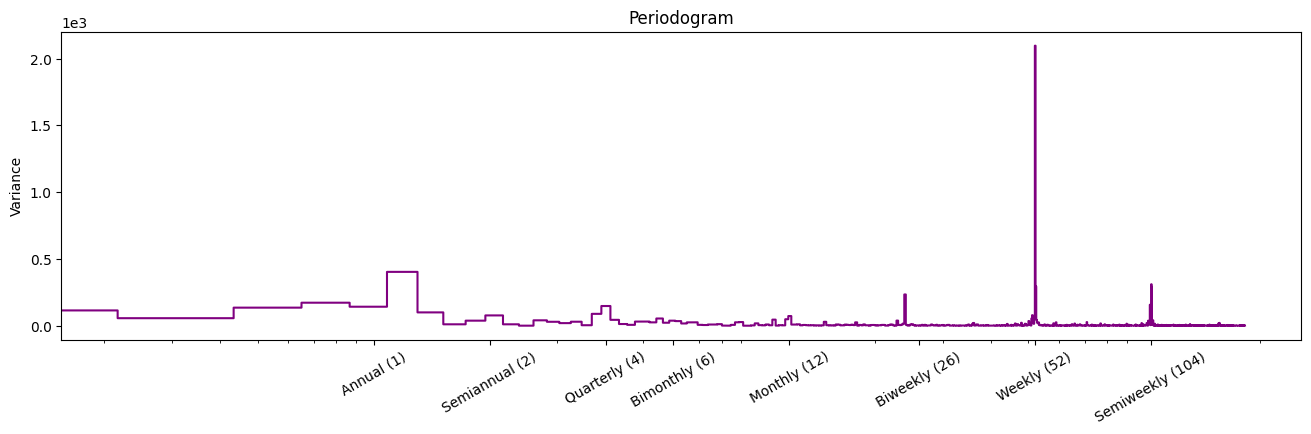

In [105]:
plot_periodogram(train.groupby(by = ["date"])["sales"].mean())

- There is strong correlation till 7 lags

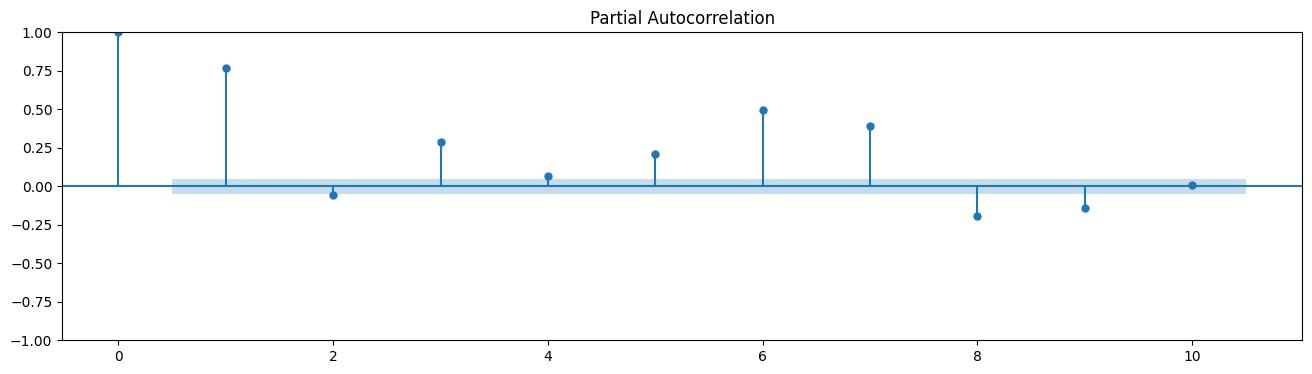

In [106]:
def partial_autocorrelation(ts, axs = None):
    '''
    ts : timeseries table
    '''
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
    plot_pacf(ts, lags = 10 , ax = axs)
    plt.show()

partial_autocorrelation(train.groupby(["date"])["sales"].mean())

## Feature Engineering

In [107]:

def date_treatment(data):

    '''
    Data : Table with a date column
    '''

    data["week_num"] = data["date"].dt.strftime("%V")
    data["Day_Name"] = data["date"].dt.day_name()
    data["Month"] = data["date"].dt.month
    data["Year"] = data["date"].dt.year
    data["Month_End"] = data["date"] + pd.offsets.MonthEnd(0)
    data["Month_Begin"] = data["date"] - pd.offsets.MonthBegin(0)
    data.loc[data["date"] != data["Month_Begin"], "Month_Begin"] = 0
    data.loc[data["date"] == data["Month_Begin"], "Month_Begin"] = 1
    data.loc[data["date"] != data["Month_End"], "Month_End"] = 0
    data.loc[data["date"] == data["Month_End"], "Month_End"] = 1
    Day_Name_Dummies = pd.get_dummies(data["Day_Name"], dtype='int')
    data["week_num"] = data["week_num"].astype('int')
    data["Month_End"] = data["Month_End"].astype('int')
    data["Month_Begin"] = data["Month_Begin"].astype('int')
    data = pd.concat([data, Day_Name_Dummies], axis=1)
    
    return data

## To add trend line
def add_trend(tbl):
    '''
    tbl : Table with time period of sales
    '''
    
    num_list = np.array([i+1 for i in range(len(tbl))])
    sqr_list = np.square(num_list)

    trend_line = pd.DataFrame({"Trend":num_list,"Trend_Square":sqr_list})

    trend_line["date"] = tbl["date"]

    return trend_line

## To add seasonality
def fourier_features(index, freq, order):
    '''
    
    index : Date index
    freq : frequenct of the seasonality
    order : order of fourier features

    '''
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1/freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}":np.sin(i*k),
            f"cos_{freq}_{i}":np.cos(i*k)
            })
    return pd.DataFrame(features, index=index)

## To add seasonality in the data
def add_seasonality(period, freq, order):
    """
    period : period to calculate seasonality
    feq : Frequency of the seasonality
    order : Order of the seasonality
    """

    seasonality = pd.DataFrame()
    
    for i in freq:
        freq_seasonality = fourier_features(period, freq=i,order=order)
        seasonality = pd.concat([seasonality, freq_seasonality], axis=1)
    
    seasonality.reset_index(inplace=True)
    seasonality.rename(columns={"index":"date"}, inplace=True)
    seasonality["date"] = seasonality["date"].dt.to_timestamp()

    return seasonality

def make_future_lags(train,str_nbr, ctgry):
    
    '''
    str_nbr : List of all the store numbers
    train : Train dataset
    ctgry : List of product family

    '''

    store_data = train[(train["store_nbr"] == str_nbr) & (train["family"] == ctgry)][["date", "store_nbr","family", "sales"]]
    
    ## 16 step ahead forecast
    store_m_step = make_multistep_target(store_data["sales"], steps=16)
    store_m_step.index = store_data["date"]
    store_m_step.dropna(inplace=True)
    
    ## lag for store data
    store_1_lag = make_lags(store_data,"sales",7,store_data["date"])
    
    ## common points
    y_step, X_step = store_m_step.align(store_1_lag, join="inner", axis = 0)

    model = LinearRegression()
    model.fit(X_step, y_step)

    forecast_horizon = store_1_lag.iloc[-1:,:]
    forecast_result = pd.DataFrame(model.predict(forecast_horizon), index = forecast_horizon.index, columns=y_step.columns)

    ## Actual vs prediction comparison
    
    Forecast_Sale = pd.DataFrame({"sales":forecast_result.iloc[-1].reset_index(drop=True)},)
    Forecast_Sale.index = pd.period_range(start="2017-08-16", end = "2017-08-31")
    prev_sales = pd.DataFrame({"sales":store_data["sales"][-15:].reset_index(drop = True)})
    prev_sales.index = pd.period_range(start="2017-08-01", end = "2017-08-15")

    forecast_data = pd.concat([prev_sales,Forecast_Sale], axis = 0)

    forecast_lag = make_lags(forecast_data, "sales", 7, forecast_data.index)

    forecast_lag = forecast_lag.iloc[-16:,:]
    forecast_lag.reset_index(inplace=True)
    forecast_lag.rename(columns={"index":"date"}, inplace=True)
    forecast_lag["store_nbr"] = str_nbr
    forecast_lag["family"] = ctgry

    return forecast_lag

def lag_for_prediction(train):
    
    '''
    
    train : train dataset

    '''

    lag_for_forecast = pd.DataFrame()
    stores_number = [i for i in train["store_nbr"].unique()]
    families = [j for j in train["family"].unique()]
    for str in stores_number:
        for fam in families:
            forecast_lag = make_future_lags(train,str,fam)
            lag_for_forecast = pd.concat([lag_for_forecast, forecast_lag], axis = 0)

    lag_for_forecast["date"] = lag_for_forecast["date"].dt.to_timestamp()

    return lag_for_forecast

def make_lags(data, clm,lags,idx):
    '''
    data : table with columns which are there in clm
    lags : Number of lags
    clm : Column where lags need to be applied
    idx : index for the dataframe
    '''
    lag_data = pd.DataFrame()
    for i in range(1,lags+1):
        lag_1 = data[[clm]].shift(i)
        lag_1.rename(columns = {clm:f"lag_{i}"}, inplace=True)
        lag_data = pd.concat([lag_data, lag_1], axis = 1)
    lag_data.index = idx
    lag_data.dropna(inplace=True)
    return lag_data

def make_multistep_target(ts, steps):
    '''
    ts : numpy array with the values
    steps : Number of steps we want to predict ahead
    '''
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def add_lag_features(df):
    '''
    df : table with sales
    '''
    for lag in range(1, 8):
        df[f'lag_{lag}'] = df['sales'].shift(lag*1782)
    return df.dropna()

In [108]:
## Since, we are using lags to train our model. So, during the period of prediction we will require lag values as well.
## Make Future lags helps in creating lag features of for coming 16 days using linear regression

def make_future_lags(train,str_nbr, ctgry):
    
    '''
    str_nbr : List of all the store numbers
    train : Train dataset
    ctgry : List of product family

    '''

    store_data = train[(train["store_nbr"] == str_nbr) & (train["family"] == ctgry)][["date", "store_nbr","family", "sales"]]
    
    ## 16 step ahead forecast
    store_m_step = make_multistep_target(store_data["sales"], steps=16)
    store_m_step.index = store_data["date"]
    store_m_step.dropna(inplace=True)
    
    ## lag for store data
    store_1_lag = make_lags(store_data,"sales",7,store_data["date"])
    
    ## common points
    y_step, X_step = store_m_step.align(store_1_lag, join="inner", axis = 0)

    model = LinearRegression()
    model.fit(X_step, y_step)

    forecast_horizon = store_1_lag.iloc[-1:,:]
    forecast_result = pd.DataFrame(model.predict(forecast_horizon), index = forecast_horizon.index, columns=y_step.columns)

    ## Actual vs prediction comparison
    
    Forecast_Sale = pd.DataFrame({"sales":forecast_result.iloc[-1].reset_index(drop=True)},)
    Forecast_Sale.index = pd.period_range(start="2017-08-16", end = "2017-08-31")
    prev_sales = pd.DataFrame({"sales":store_data["sales"][-15:].reset_index(drop = True)})
    prev_sales.index = pd.period_range(start="2017-08-01", end = "2017-08-15")

    forecast_data = pd.concat([prev_sales,Forecast_Sale], axis = 0)

    forecast_lag = make_lags(forecast_data, "sales", 7, forecast_data.index)

    forecast_lag = forecast_lag.iloc[-16:,:]
    forecast_lag.reset_index(inplace=True)
    forecast_lag.rename(columns={"index":"date"}, inplace=True)
    forecast_lag["store_nbr"] = str_nbr
    forecast_lag["family"] = ctgry

    return forecast_lag


In [109]:
def lag_for_prediction(train):
    
    '''
    
    train : train dataset

    '''

    lag_for_forecast = pd.DataFrame()
    stores_number = [i for i in train["store_nbr"].unique()]
    families = [j for j in train["family"].unique()]
    for str in stores_number:
        for fam in families:
            forecast_lag = make_future_lags(train,str,fam)
            lag_for_forecast = pd.concat([lag_for_forecast, forecast_lag], axis = 0)

    lag_for_forecast["date"] = lag_for_forecast["date"].dt.to_timestamp()

    return lag_for_forecast

In [110]:
def fourier_features(index, freq, order):
    '''
    
    index : Date index
    freq : frequenct of the seasonality
    order : order of fourier features

    '''
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1/freq) * time
    features = {}
    
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}":np.sin(i*k),
            f"cos_{freq}_{i}":np.cos(i*k)
            })
    
    return pd.DataFrame(features, index=index)

In [111]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    '''
    ts : Sales with timeseries index
    '''
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

- Strong Weekly seasonality, along with little semiweekly, yearly seasonality

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

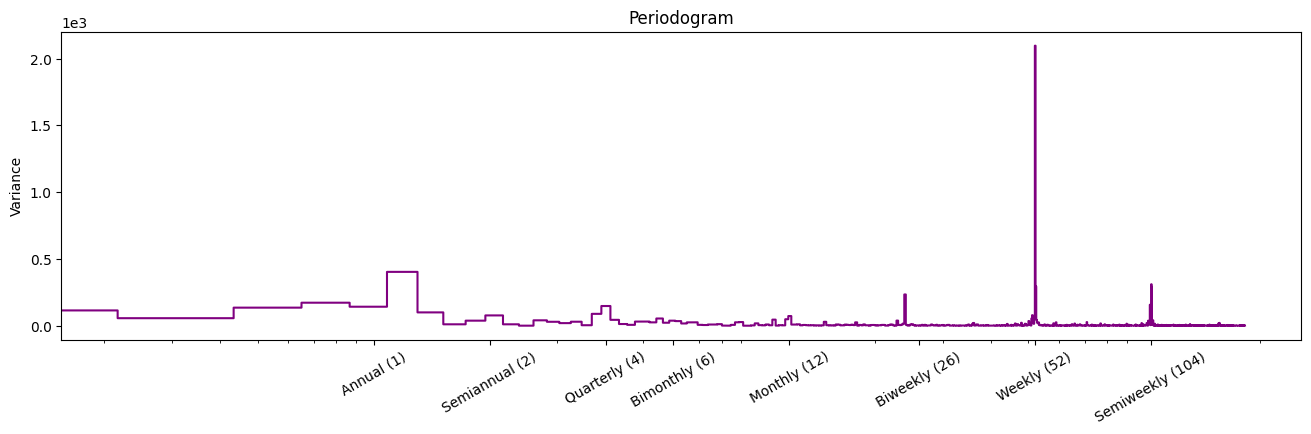

In [112]:
fig, axs = plt.subplots(nrows = 1, ncols =1, figsize=(16,4))
plot_periodogram(train.groupby(by = ["date"])["sales"].mean(), ax = axs)

In [113]:
## To add seasonality in the data

def add_seasonality(period, freq, order):
    """
    
    period : period to calculate seasonality
    feq : Frequency of the seasonality
    order : Order of the seasonality
    
    """

    seasonality = pd.DataFrame()
    
    for i in freq:
        freq_seasonality = fourier_features(period, freq=i,order=order)
        seasonality = pd.concat([seasonality, freq_seasonality], axis=1)
    
    seasonality.reset_index(inplace=True)
    seasonality.rename(columns={"index":"date"}, inplace=True)
    seasonality["date"] = seasonality["date"].dt.to_timestamp()

    return seasonality

In [114]:
## To add trend line
def add_trend(tbl):
    
    '''
    tbl : Table with time period of sales
    '''
    
    num_list = np.array([i+1 for i in range(len(tbl))])
    sqr_list = np.square(num_list)

    trend_line = pd.DataFrame({"Trend":num_list,"Trend_Square":sqr_list})

    trend_line["date"] = tbl["date"]

    return trend_line

## Data Preprocessing

In [115]:
## test data pre processing

def data_preprocessing_2(train,test,transactions, Oil, stores,Holiday_events):

    """
    train : train data for sales
    test : test data for sales
    transactions : number of trnasaction for the same time period
    Oil : Oil prices for the same time period
    Stores : Store information
    Holiday_Events : Holiday Event during the same time period
     
    """
    
    stores = string_processing(stores,['city','state'])

    Local,Regional, National = Holiday_func(Holiday_events)

    train_data = merge_tables(train,transactions, Oil, stores, National, Local, Regional)
    test_data = merge_tables(test,transactions, Oil, stores, National, Local, Regional)

    ### Rank based upon product family sales
    family_rank = train_data.groupby(by = ["family"], as_index=False)["sales"].mean().sort_values(by = ["sales"], ascending=False)\
        .reset_index(drop = True).reset_index().drop(columns= ["sales"]).rename(columns = {"index":"family_rank"})

    ### Rank based upon store sales
    store_rank = train_data.groupby(by = ["store_nbr"], as_index=False)["sales"].mean().sort_values(by = ["sales"], ascending=False)\
        .reset_index(drop = True).reset_index().drop(columns= ["sales"]).rename(columns = {"index":"store_rank"})

    train_data = pd.merge(train_data, family_rank, left_on = ["family"], right_on=["family"])
    train_data = pd.merge(train_data, store_rank, left_on = ["store_nbr"], right_on=["store_nbr"])
    
    test_data = pd.merge(test_data, family_rank, left_on = ["family"], right_on=["family"])
    test_data = pd.merge(test_data, store_rank, left_on = ["store_nbr"], right_on=["store_nbr"])
    

    train_data = date_treatment(train_data)
    test_data = date_treatment(test_data)
    train_data = add_lag_features(train_data)

    future_lags = lag_for_prediction(train)
    test_data = pd.merge(test_data, future_lags, left_on = ["date","store_nbr", "family"], right_on=["date","store_nbr", "family"], how="left")

    ## Seasonality from the start of the train data to the end to the test data
    seasonality = add_seasonality(pd.period_range('2013-01-01', '2017-08-31'), freq=[3.5,7,30,365], order=1)
    trend_line = add_trend(seasonality[["date"]])

    ### Merge of all components for train dataset
    train_data_seas = pd.merge(train_data, seasonality, left_on="date", right_on ="date", how="left")
    train_data_seas = pd.merge(train_data_seas, trend_line, left_on="date", right_on ="date", how="left")
    train_data_seas.drop(columns=['state', 'id', 'family','store_nbr','city', 'locale_name_x','Day_Name','type','cluster',"locale_name_y", "locale_name"], inplace=True)

    ### Merge of all components for test dataset
    test_data_seas = pd.merge(test_data, seasonality, left_on="date", right_on ="date", how="left")
    test_data_seas = pd.merge(test_data_seas, trend_line, left_on="date", right_on ="date", how="left")
    test_data_seas.drop(columns=['state', 'date','family','store_nbr','city', 'locale_name_x','Day_Name','type','cluster',"locale_name_y", "locale_name"], inplace=True)

    return train_data_seas,  test_data_seas

In [116]:
def evaluate_model(model1, time_period_table, log = False):
    
    '''
    
    model1 : Model with its specifications
    time_period_table : preprocessed table
    log : if log transformation has been applied on the model

    '''
    
    date = time_period_table[["date"]]
    if log:
        Y = np.log(time_period_table["sales"] + 1)
    else:
        Y = time_period_table["sales"]
    X = time_period_table.drop(columns = ["date", "sales"])

    len_1_mnth = len(date[date["date"] >= '2017-07-16'])

    seas_train, seas_test = X[:-len_1_mnth], X[-len_1_mnth:]
    Y_seas_train, Y_seas_test = Y[:-len_1_mnth], Y[-len_1_mnth:]    

    pred_model = model1.fit(seas_train,Y_seas_train)

    y_pred = [max(0,i) for i in pred_model.predict(seas_test)]
    y_fitted = [max(0,i) for i in pred_model.predict(seas_train)]

    if log:
        y_pred = np.exp(y_pred) - 1
        y_fitted = np.exp(y_fitted) - 1
        Y_seas_train = np.exp(Y_seas_train) - 1
        Y_seas_test = np.exp(Y_seas_test) - 1
        print("Train R2 score : ",r2_score(Y_seas_train,y_fitted),"Test R2 score : ",r2_score(Y_seas_test,y_pred))
        Log_error = RMSLE(Y_seas_test,y_pred)
    else:
        print("Train R2 score : ",r2_score(Y_seas_train,y_fitted),"Test R2 score : ",r2_score(Y_seas_test,y_pred))
        Log_error = RMSLE(Y_seas_test,y_pred)

    result = pd.concat([time_period_table[["date", "store_rank"]][-len_1_mnth:].reset_index(drop = True),Y_seas_test.reset_index(drop = True),pd.Series(y_pred)],axis = 1)
    result.columns = ["date", "store_rank", "sales", "pred"]

    Feature_Importance = pd.DataFrame({'Features': model1.feature_names_in_,'Importance':model1.feature_importances_})
    Feature_Importance = Feature_Importance.sort_values(by = ["Importance"], ascending = False).reset_index(drop=True)

    return result, Log_error, Feature_Importance

In [117]:
def plot_result(df):
    '''
    df : result dataframe with actual and predicted values
    '''
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    sns.lineplot(data=df, x="date", y = "sales", ci=False, label ="actual", ax = axs)
    sns.lineplot(data=df, x="date", y = "pred", ci=False, label ="pred", ax= axs)
    plt.show()

In [118]:
train_data_seas_2,test_data_seas_2  = data_preprocessing_2(train,test,transactions, Oil, stores,Holiday_events)

## First Approach

In [119]:
model1 = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, min_child_weight = 100, sub_sample=0.8, colsample_bytree = 0.9)
result_1, error_1, Feature_Importance_1 = evaluate_model(model1, train_data_seas_2, log =False)

Train R2 score :  0.9752013716481052 Test R2 score :  0.9728680707543319


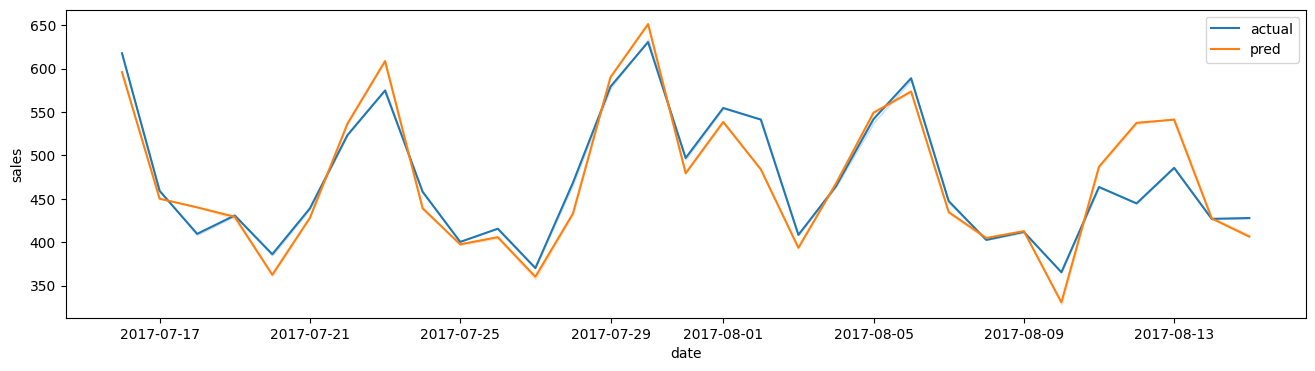

In [120]:
plot_result(result_1)

## Second Approach

In [121]:
def outliers_removal(df, clm):
    '''

    df : Preprocessed DataFrame
    clm : numerical variable to calculate the outliers
    
    '''

    first_quartile = df[clm].quantile(0.25)
    third_quantile = df[clm].quantile(0.75)

    IQR = third_quantile - first_quartile

    LB = first_quartile - 1.5*IQR
    UB = third_quantile + 1.5*IQR

    df = df[(df[clm] >= LB) & (df[clm] <= UB)]

    return df

In [122]:
train_data_seas_4 = train_data_seas_2.copy()
train_data_seas_4  = outliers_removal(train_data_seas_4,'sales')

In [123]:
model1 = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 4, min_child_weight = 100, sub_sample=0.8, colsample_bytree = 0.9)
result_2, error_2, Feature_Importance_2 = evaluate_model(model1, train_data_seas_4, log =False)

Train R2 score :  0.9400698673040131 Test R2 score :  0.9419670132544364


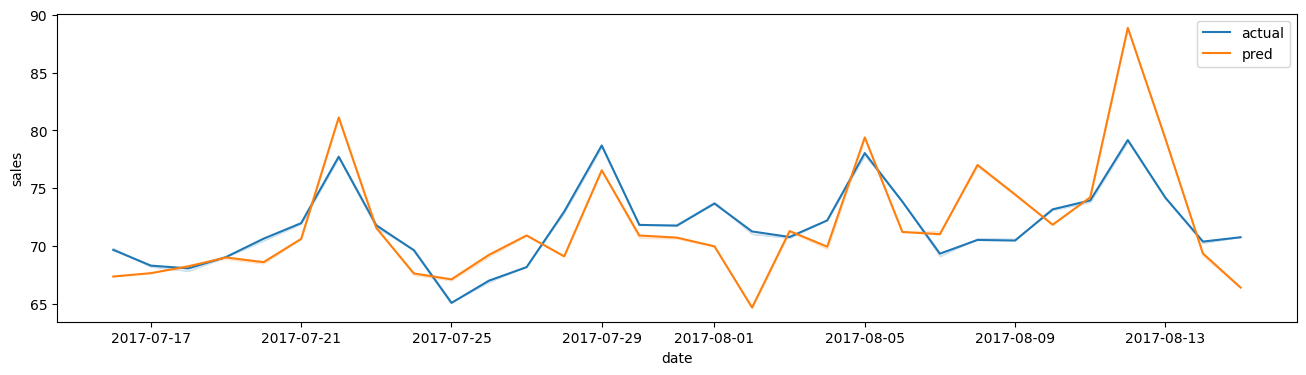

In [124]:
plot_result(result_2)

## Third Approach

In [125]:
train_data_seas_4 = train_data_seas_2.copy()

model1 = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.05, max_depth = 9, min_child_weight = 10, sub_sample=0.8, colsample_bytree = 0.8)
result_3, error_3, Feature_Importance_3 = evaluate_model(model1, train_data_seas_4, log =True)

Train R2 score :  0.9748580116555406 Test R2 score :  0.9748571497188604


In [126]:
error_3

0.38198634479659604

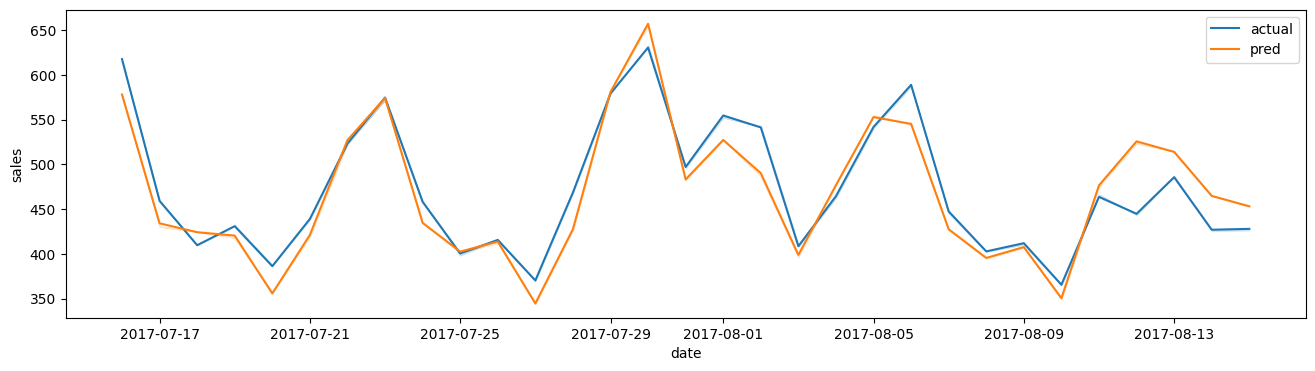

In [127]:
def plot_result(df):
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    sns.lineplot(data=df, x="date", y = "sales", ci=False, label ="actual", ax = axs)
    sns.lineplot(data=df, x="date", y = "pred", ci=False, label ="pred", ax= axs)
    plt.show()

plot_result(result_3)

In [128]:
def submission(df, model, log = False):
    """
    df : test data with the necessary variables
    model : any model that has been trained on the train data
    """
    
    test_id = df[["id"]]
    test_data = df.drop(columns = ["id"])
    model_pred = pd.DataFrame({"sales":model.predict(test_data)})

    if log:
        model_pred["sales"] = np.exp(model_pred["sales"]) -1

    submission_data = pd.concat([test_id,model_pred], axis=1)

    return submission_data

In [129]:
submission(test_data_seas_2, model1, log = True)

,id,sales
0,3000888,4.811
1,3000889,0.041
2,3000890,5.861
3,3000891,2536.057
4,3000892,0.047
...,...,...
28507,3029395,432.707
28508,3029396,113.048
28509,3029397,1514.718
28510,3029398,32.822
